# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2 : Propiedades en Venta</center>
## <center>Parte 1</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')
import shapely.speedups
from IPython.display import Image
import re
from itertools import combinations
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [28]:
viviendas_train=pd.read_csv('./TP1/Datasets/viviendas_caba_train.csv').copy()
viviendas_test=pd.read_csv('./TP1/Datasets/viviendas_caba_test.csv').copy()

In [29]:
viviendas = pd.concat([viviendas_train, viviendas_test]).reset_index()

# 1.Procesamiento del Lenguaje Natural

## a) Ampliación del dataset

In [30]:
veces_palabra = {}
indice_de_palabra = {}
for indice in viviendas.index:
    property_title = viviendas.loc[indice,:].property_title.lower()

    if "/" in property_title:
        property_title = property_title.replace("/"," ")
    if "." in property_title:
        property_title = property_title.replace("."," ")
    if "," in property_title:
        property_title = property_title.replace(","," ")
    if "-" in property_title:
        property_title = property_title.replace("-"," ")
    if "ó" in property_title:
        property_title = property_title.replace("ó","o")
    if "!" in property_title:
        property_title = property_title.replace("!"," ")

    property_title = property_title.split()
    
    for palabra in property_title:
        palabra = ''.join(char for char in palabra if char.isalnum())
        if palabra.isnumeric() or len(palabra) < 3:
            continue
        veces_palabra[palabra] = veces_palabra.get(palabra, 0)
        veces_palabra[palabra] +=1 

        indice_de_palabra[palabra]  = indice_de_palabra.get(palabra, list())
        indice_de_palabra[palabra].append(indice)


In [31]:
def agregar_aspecto(aspecto, palabras_clave, dataset):
    for palabra in indice_de_palabra.keys():
        for palabra_clave in palabras_clave:
            if palabra_clave in palabra:
                for i in indice_de_palabra[palabra]:
                    dataset.loc[i, aspecto] = 'sí'
    dataset[aspecto].fillna('unknown', inplace=True)

    
    print(f'cantidad de {aspecto}: { (dataset[aspecto] == "sí").sum() }')

In [32]:
palabras_a_ignorar = set(['departamento', 'depto', 'casa', 'ph', 'venta', 'amb', 'ambientes', 'con'])
for barrio in viviendas_train.barrio:
    for t in barrio.split():
        palabras_a_ignorar.add(t.lower())
for palabra in palabras_a_ignorar:
    if palabra in veces_palabra:
        veces_palabra.pop(palabra)
        indice_de_palabra.pop(palabra)

Ordenamos palabras por cantidad de apariciones para buscar posibles aspectos que sumen valor a nuestro dataset

In [33]:
sorted(veces_palabra.items(),  key=lambda x:x[1])[::-1]
print((sorted(veces_palabra.items(),  key=lambda x:x[1])[::-1])[:100])

[('balcon', 12291), ('cochera', 10563), ('monoambiente', 7156), ('terraza', 6564), ('estrenar', 5194), ('patio', 5062), ('amenities', 4632), ('luminoso', 4596), ('excelente', 4338), ('piso', 4099), ('frente', 3789), ('oportunidad', 3193), ('parrilla', 2833), ('apto', 2625), ('muy', 2595), ('vista', 2404), ('dependencia', 2223), ('baulera', 2121), ('semipiso', 1953), ('dpto', 1933), ('dos', 1826), ('reciclado', 1804), ('expensas', 1801), ('alto', 1796), ('hermoso', 1783), ('duplex', 1759), ('torre', 1724), ('profesional', 1713), ('dep', 1584), ('impecable', 1473), ('nuevo', 1445), ('coch', 1428), ('ambiente', 1423), ('hollywood', 1397), ('amplio', 1322), ('pozo', 1300), ('ubicacion', 1216), ('cocheras', 1198), ('propia', 1171), ('dormitorios', 1169), ('edificio', 1135), ('sin', 1125), ('pileta', 1086), ('gran', 1073), ('retasado', 977), ('tipo', 963), ('divisible', 927), ('chico', 923), ('abierta', 923), ('zona', 906), ('full', 894), ('pueyrredon', 844), ('fija', 768), ('categoría', 767

Viendo lo anterior buscamos aspectos importantes y palabras claves que los identifiquen para agregarlos al dataset:

+ A estrenar/nuevo
+ Patio/Jardín
+ balcón
+ cochera
+ pileta
+ parrilla
+ terraza
+ monoambiente

In [34]:
agregar_aspecto('a_estrenar', ['estrenar', 'nuevo'], viviendas)
agregar_aspecto('patio_jardin', ['pat', 'jard'], viviendas)
agregar_aspecto('balcon', ['balc'], viviendas)
agregar_aspecto('cochera', ['coche', 'garag'], viviendas)
agregar_aspecto('pileta', ['pil', 'pisc'], viviendas)
agregar_aspecto('parrilla', ['parr'], viviendas)
agregar_aspecto('terraza', ['terra'], viviendas)
agregar_aspecto('monoambiente', ['mono'], viviendas)

cantidad de a_estrenar: 6634
cantidad de patio_jardin: 6569
cantidad de balcon: 12821
cantidad de cochera: 12375
cantidad de pileta: 1842
cantidad de parrilla: 3048
cantidad de terraza: 7517
cantidad de monoambiente: 8109


In [35]:
viviendas.head(5)

,index,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,...,property_title,geometry,a_estrenar,patio_jardin,balcon,cochera,pileta,parrilla,terraza,monoambiente
0,0,2021-12-15,2021-12-25,-34.555049,-58.490513,Saavedra,Departamento,2.0,1.0,58.0,...,Departamento - Saavedra,POINT (-58.4905135 -34.5550487),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
1,1,2021-05-20,2021-06-05,-34.546991,-58.478553,Saavedra,Departamento,2.0,1.0,48.0,...,Departamento - Saavedra,POINT (-58.4785532 -34.546991),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
2,2,2021-03-20,2021-04-16,-34.570842,-58.491805,Villa Urquiza,Departamento,2.0,1.0,62.0,...,Venta Depto 2 amb Anticipo + Cuotas CAC V. Urq...,POINT (-58.4918048 -34.5708421),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
3,3,2021-07-17,2021-10-16,-34.589251,-58.402106,Recoleta,Departamento,3.0,2.0,60.0,...,Excelente 3 ambientes en venta en Barrio Recoleta,POINT (-58.4021058 -34.5892511),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
4,4,2021-07-02,2022-02-09,-34.626290,-58.437632,Caballito,Departamento,3.0,2.0,67.0,...,VENTA DEPARTAMENTO 3 AMB. EN CABALLITO,POINT (-58.4376325 -34.6262899),unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown


## b) Modelos

### Preprocesamiento

In [36]:
viviendas.loc[:,"a_estrenar"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"patio_jardin"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"balcon"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"cochera"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"pileta"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"parrilla"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"terraza"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)
viviendas.loc[:,"monoambiente"].replace(to_replace=['unknown','sí'],value=[0,1],inplace=True)

In [37]:
viviendas_train, viviendas_test = train_test_split(viviendas, test_size=0.2, random_state=2)
x_train_ampliado = viviendas_train[['latitud','longitud', 'property_surface_total', 'property_surface_covered', 'a_estrenar', 'patio_jardin', 'balcon', 'cochera', 'pileta', 'parrilla', 'terraza', 'monoambiente']]
x_test_ampliado = viviendas_test[['latitud','longitud', 'property_surface_total', 'property_surface_covered', 'a_estrenar', 'patio_jardin', 'balcon', 'cochera', 'pileta', 'parrilla', 'terraza', 'monoambiente']]

y_train_ampliado = viviendas_train.property_price
y_test_ampliado = viviendas_test.property_price

In [38]:
scaler = MinMaxScaler() 
x_train_ampliado = scaler.fit_transform(x_train_ampliado)
x_test_ampliado = scaler.transform(x_test_ampliado)

### Utilizando los mismos hiperparámetros seleccionados en el TP 1

In [39]:
"""
rand_xgb_params_tp1 = joblib.load('./TP1/Models/rand_xgb')
rand_xgb_params_tp1.fit(x_train_ampliado, y_train_ampliado)
joblib.dump(rand_xgb_params_tp1, './Models/xgb_ampliado_params_tp1')
"""

"\nrand_xgb_params_tp1 = joblib.load('./TP1/Models/rand_xgb')\nrand_xgb_params_tp1.fit(x_train_ampliado, y_train_ampliado)\njoblib.dump(rand_xgb_params_tp1, './Models/xgb_ampliado_params_tp1')\n"

In [40]:
rand_xgb_ampliado_params_tp1 = joblib.load('./Models/xgb_ampliado_params_tp1')
best_xgb_regressor_ampliado_params_tp1 = rand_xgb_ampliado_params_tp1.best_estimator_

In [41]:
#Predicción con mejor estimador
y_pred_test_xgb = best_xgb_regressor_ampliado_params_tp1.predict(x_test_ampliado)

#Coef. de Determinación R2
r2_score_test_xgb = r2_score(y_test_ampliado, y_pred_test_xgb)
print(f'Coef. de Determinación R2: {r2_score_test_xgb}')

#Coef. de Determinación R2 ajustado
n = x_test_ampliado.shape[0] #n = count of rows in your dataset used for train or test
p = 4 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_xgb)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9107357812035757
Coef. de Determinación R2 ajustado: 0.9107165546204522
El error (mse) de test es: 7961554870.09518
El error (rmse) de test es: 89227.54546716603


In [42]:
performance_test = pd.DataFrame({'Valor Real': y_test_ampliado,
                            'Prediccion': y_pred_test_xgb.round(),
                            'Error': y_test_ampliado - y_pred_test_xgb.round()})
performance_test.head()

,Valor Real,Prediccion,Error
63184,69900.0,78762.0,-8862.0
62628,108000.0,141852.0,-33852.0
75408,75000.0,106964.0,-31964.0
49022,420000.0,661185.0,-241185.0
29265,49900.0,52985.0,-3085.0


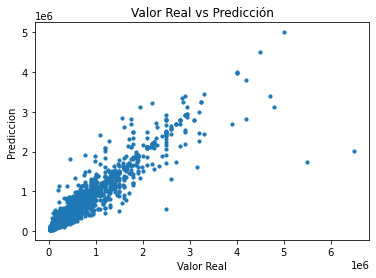

In [43]:
scatter_real_predict_test = performance_test.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


Vemos que las métricas con el dataset ampliado mejoran considerablemente en comparación con las del dataset sin ampliar.  
  
  Métricas sin ampliar:  
+    Coef. de Determinación R2: 0.9019
+    Coef. de Determinación R2 ajustado: 0.9019
+    El error (mse) de test es: 9168434434.6191
+    El error (rmse) de test es: 95751.9421

In [44]:
def porcentaje_de_cambio_de_metricas(nombre_metrica, metrica_nueva, metrica_anterior):
    porcentaje = round(metrica_nueva*100/ metrica_anterior -100,3)
    if nombre_metrica == 'R2' or 'R2 ajustado':
        if porcentaje < 0:
            print(f'la metrica {nombre_metrica} es un {-porcentaje}% peor')
        else:
            print(f'la metrica {nombre_metrica} es un {porcentaje}% mejor')

    elif nombre_metrica == 'RMSE' or 'MSE':
        if porcentaje > 0:
            print(f'la metrica {nombre_metrica} es un {-porcentaje}% peor')
        else:
            print(f'la metrica {nombre_metrica} es un {porcentaje}% mejor')


Cambio de métricas respecto al dataset sin ampliar (con mismos hiperparametros):

In [45]:
porcentaje_de_cambio_de_metricas('R2', 0.9107357812035757, 0.9019645365048344)
porcentaje_de_cambio_de_metricas('RMSE', 89227.54546716603, 95751.94219763453 )

la metrica R2 es un 0.972% mejor
la metrica RMSE es un 6.814% peor


### Utilizando hiperparámetros optimizados con el nuevo dataset ampliado.

decidimos usar GridSearchCV, porque usando RandomSearchCV no obteníamos hiperparámetros distintos a los del dataset sin ampliar

In [46]:
"""#Grilla de Parámetros
params_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

#Clasificador KNN
xgb_regressor_ampliado = xgb.XGBRegressor()

grid_xgb_ampliado_param_tp2 = GridSearchCV(xgb_regressor_ampliado, params_grid, cv=5, scoring='r2')

grid_xgb_ampliado_param_tp2.fit(x_train_ampliado, y_train_ampliado)
joblib.dump(grid_xgb_ampliado_param_tp2, './Models/grid_xgb_ampliado_param_tp2')
"""

"#Grilla de Parámetros\nparams_grid = {\n    'n_estimators': [100, 400, 800],\n    'max_depth': [3, 6, 9],\n    'learning_rate': [0.05, 0.1, 0.20],\n    'min_child_weight': [1, 10, 100]\n    }\n\n#Clasificador KNN\nxgb_regressor_ampliado = xgb.XGBRegressor()\n\ngrid_xgb_ampliado_param_tp2 = GridSearchCV(xgb_regressor_ampliado, params_grid, cv=5, scoring='r2')\n\ngrid_xgb_ampliado_param_tp2.fit(x_train_ampliado, y_train_ampliado)\njoblib.dump(grid_xgb_ampliado_param_tp2, './Models/grid_xgb_ampliado_param_tp2')\n"

In [47]:
grid_xgb_ampliado_param_tp2 = joblib.load('./Models/grid_xgb_ampliado_param_tp2')
best_xgb_ampliado_param_tp2 = grid_xgb_ampliado_param_tp2.best_estimator_

In [48]:
#Predicción con mejor estimador
y_pred_test_xgb = best_xgb_ampliado_param_tp2.predict(x_test_ampliado)

#Coef. de Determinación R2
r2_score_test_xgb = r2_score(y_test_ampliado, y_pred_test_xgb)
print(f'Coef. de Determinación R2: {r2_score_test_xgb}')

#Coef. de Determinación R2 ajustado
n = x_test_ampliado.shape[0] #n = count of rows in your dataset used for train or test
p = 12 #p = count of independent variables
print(f'Coef. de Determinación R2 ajustado: {1-(1-r2_score_test_xgb)*(n-1)/(n-p-1)}')

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test_ampliado,
        y_pred  = y_pred_test_xgb,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

Coef. de Determinación R2: 0.9127994404557074
Coef. de Determinación R2 ajustado: 0.912743069895209
El error (mse) de test es: 7777495270.509185
El error (rmse) de test es: 88190.10868861193


In [49]:
performance_test = pd.DataFrame({'Valor Real': y_test_ampliado,
                            'Prediccion': y_pred_test_xgb.round(),
                            'Error': y_test_ampliado - y_pred_test_xgb.round()})
performance_test.head()

,Valor Real,Prediccion,Error
63184,69900.0,78191.0,-8291.0
62628,108000.0,143328.0,-35328.0
75408,75000.0,104908.0,-29908.0
49022,420000.0,675072.0,-255072.0
29265,49900.0,56399.0,-6499.0


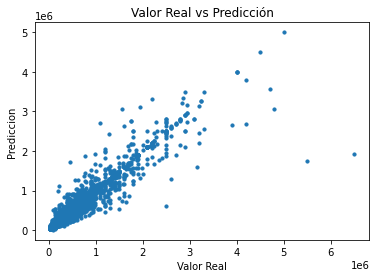

In [50]:
scatter_real_predict_test = performance_test.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


Cambio de métricas buscando nuevos hiperparámetros

In [51]:
porcentaje_de_cambio_de_metricas('R2', 0.9127994404557074, 0.9107357812035757)
porcentaje_de_cambio_de_metricas('RMSE', 88190.10868861193, 89227.54546716603)

la metrica R2 es un 0.227% mejor
la metrica RMSE es un 1.163% peor
